In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchtune.modules import RotaryPositionalEmbeddings
import csv
import os
from loss_curve_visualization import plot_loss_curves
import torch.nn.functional as F

In [28]:
data = np.load(r"D:\Praharsha\code\CAMZ\data\interim\boundingboxes_array.npy", allow_pickle=True)
rows_to_remove = [443, 474]
data = np.delete(data, rows_to_remove, axis=0)

In [29]:
mask = np.array([np.any(video == None) for video in data])  # Identify rows with None
data = data[~mask]
data = data.astype(np.float32)
data.shape

(586, 300, 2)

In [ ]:
mean = data.mean(axis=(0, 1), keepdims=True)
std = data.std(axis=(0, 1), keepdims=True)
data = (data - mean) / std

In [31]:
labels_df = pd.read_csv(r"D:\Praharsha\code\CAMZ\data\interim\verdict.csv")  # Adjust delimiter if needed
print(labels_df.head())

verdict = labels_df['Verdict']
verdicts = verdict[~mask]
print(verdicts.shape)

   Name  Inactivity score  Time_bottom score  Time_top score  \
0  1L.1                 0                  1               1   
1  1L.2                 0                  1               1   
2  1L.3                 0                  1               1   
3  1L.4                 0                  1               1   
4  1L.5                 0                  0               1   

   Large_angle score  Small_angle score  Final Score  Verdict  
0                  1                  0         0.50        1  
1                  1                  0         0.50        1  
2                  1                  1         0.70        1  
3                  0                  1         0.50        1  
4                  1                  1         0.55        1  
(586,)


In [32]:
data = torch.tensor(data, dtype=torch.float32)

# Calculate split sizes
total_samples = data.shape[0]
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

# Split datasets
train_data, val_data, test_data = random_split(data, [train_size, val_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=2, seq_len=300, latent_dim=64, num_heads=4, ff_dim=512, num_layers=4):
        super(TransformerAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.head_dim = latent_dim // num_heads

        # Input projection
        self.input_proj = nn.Linear(input_dim, latent_dim)
        self.pos_encoding = RotaryPositionalEmbeddings(dim=self.head_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.encoder_norm = nn.LayerNorm(latent_dim)
        # Latent vector via pooling
        self.latent_pool = nn.AdaptiveAvgPool1d(1)
        
        self.projection_head = nn.Sequential(
        nn.Linear(latent_dim, latent_dim),
        nn.ReLU(),
        nn.Linear(latent_dim, latent_dim)
        )


    def apply_rope(self, x):
        # x: (B, S, D)
        B, S, D = x.shape
        x = x.view(B, S, self.num_heads, self.head_dim)   # (B, S, N_H, H_D)
        x = self.pos_encoding(x)                          # Apply RoPE
        x = x.view(B, S, D)                               # Back to (B, S, D)
        return x
    
    def add_noise(self, x, noise_std=0.01):
        return x + noise_std * torch.randn_like(x)

    def rotate(self, x, angle_range=(-15, 15)):
        angle = torch.empty(1).uniform_(*angle_range).item()
        rad = torch.deg2rad(torch.tensor(angle))
        rotation_matrix = torch.tensor([
            [torch.cos(rad), -torch.sin(rad)],
            [torch.sin(rad),  torch.cos(rad)]
        ], device=x.device)
        return torch.matmul(x, rotation_matrix)
    
    def augment(self, x):
        if torch.rand(1).item() < 0.5:
            x = self.add_noise(x)
        else:
            x = self.rotate(x)
        return x

    def forward(self, x, apply_aug=True):
        if apply_aug:
            x = self.augment(x)  # Apply noise or rotation only if True

        x = self.input_proj(x)  # (B, S, latent_dim)
        x = self.apply_rope(x)
        x = self.encoder_norm(self.encoder(x))
        x_pooled = self.latent_pool(x.permute(0, 2, 1)).squeeze(-1)
        z = self.projection_head(x_pooled)
        z = nn.functional.normalize(z, dim=1)

        return z


In [34]:

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, z1, z2):
        """
        z1, z2: Tensor of shape (B, D) — representations from two views
        """
        B = z1.size(0)
        z = torch.cat([z1, z2], dim=0)  # (2B, D)

        # Normalize representations
        z = F.normalize(z, dim=1)

        # Cosine similarity matrix (2B x 2B)
        sim = torch.matmul(z, z.T) / self.temperature

        # Mask out self-similarities
        mask = torch.eye(2 * B, dtype=torch.bool).to(z.device)
        sim.masked_fill_(mask, -1e9)

        # Create labels for positive pairs
        targets = torch.cat([torch.arange(B, 2 * B), torch.arange(0, B)]).to(z.device)

        # Compute cross-entropy loss
        loss = F.cross_entropy(sim, targets)
        return loss

In [35]:
x = torch.rand((32, 300, 2))
model = TransformerAutoencoder()
x1 = model(x)
x2 = model(x)
print(x1.shape, x2.shape)

loss = NTXentLoss()
print(loss(x1, x2))

torch.Size([32, 64]) torch.Size([32, 64])
tensor(4.1418, grad_fn=<NllLossBackward0>)


In [36]:
model = TransformerAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = NTXentLoss(temperature=0.1)

history_path = r"D:\Praharsha\code\CAMZ\models\model_history\5.0-Transformer\transformer_history.csv"
save_model_checkpoint_path = r"D:\Praharsha\code\CAMZ\models\model_history\5.0-Transformer\transformer.pth.tar"


In [37]:
def Initialize_writer(file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, mode='w', newline="") as file:
        writer = csv.writer(file)
        writer.writerow(['epoch', 'loss', 'val_loss'])

In [38]:
def validate(model, val_loader, loss_function, device='cpu'):
    model.eval()
    total_batch_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs.to(device)
            outputs1 = model(inputs)
            outputs2 = model(inputs)
            loss_per_batch = loss_function(outputs1, outputs2)
            total_batch_loss += loss_per_batch.item()
        total_loss = total_batch_loss / len(val_loader)
        print(f"NXent Loss: {total_loss:.4f}", end=" ")
    return total_loss

def train(model, train_loader, val_loader, optimizer, 
                      loss_function, history_csv_path, 
                      save_model_checkpoint_path, num_epochs=100, 
                      patience=10, delta=0.001, device='cpu'):

    Initialize_writer(history_csv_path)
    
    best_val_loss = float('inf')
    early_stopping = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            batch = batch.to(device)
            
            z1 = model(batch)
            z2 = model(batch)

            loss = loss_function(z1, z2)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Contrastive Loss: {avg_train_loss:.4f}", end=" --- ")
        val_loss = validate(model, val_loader, loss_function, device='cpu')

        # Early stopping and checkpoint logic
        if (best_val_loss - val_loss) > delta:
            best_val_loss = val_loss
            checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            print(f"\n=========Saving Checkpoint======= at Epoch:[{epoch+1}/{num_epochs}]")
            torch.save(checkpoint, save_model_checkpoint_path)
            early_stopping = 0
        else:
            early_stopping += 1

        # Log to CSV
        with open(history_csv_path, mode='a', newline="") as file:
            loss_writer = csv.writer(file)
            loss_writer.writerow([epoch+1, avg_train_loss, val_loss])

        if early_stopping >= patience:
            print(f"\n Early stopping triggered at epoch {epoch+1}")
            break

    print(f"\n Best Validation Loss: {best_val_loss:.4f}")


In [39]:
train(model, train_loader, val_loader = val_loader, optimizer=optimizer, loss_function=criterion,
      history_csv_path=history_path,
      save_model_checkpoint_path=save_model_checkpoint_path, num_epochs=100)


Epoch [1/100], Train Contrastive Loss: 1.5047 --- NXent Loss: 0.8650 
=========Saving Checkpoint======= at Epoch:[1/100]

Epoch [2/100], Train Contrastive Loss: 0.7616 --- NXent Loss: 0.5528 
=========Saving Checkpoint======= at Epoch:[2/100]

Epoch [3/100], Train Contrastive Loss: 0.4888 --- NXent Loss: 0.3803 
=========Saving Checkpoint======= at Epoch:[3/100]

Epoch [4/100], Train Contrastive Loss: 0.4498 --- NXent Loss: 0.3684 
=========Saving Checkpoint======= at Epoch:[4/100]

Epoch [5/100], Train Contrastive Loss: 0.3001 --- NXent Loss: 0.3239 
=========Saving Checkpoint======= at Epoch:[5/100]

Epoch [6/100], Train Contrastive Loss: 0.3054 --- NXent Loss: 0.3688 
Epoch [7/100], Train Contrastive Loss: 0.3545 --- NXent Loss: 0.4186 
Epoch [8/100], Train Contrastive Loss: 0.2978 --- NXent Loss: 0.3699 
Epoch [9/100], Train Contrastive Loss: 0.3148 --- NXent Loss: 0.2574 
=========Saving Checkpoint======= at Epoch:[9/100]

Epoch [10/100], Train Contrastive Loss: 0.2752 --- NXent 

The best loss of 0.0879587809053751 achieved at Epoch: 54


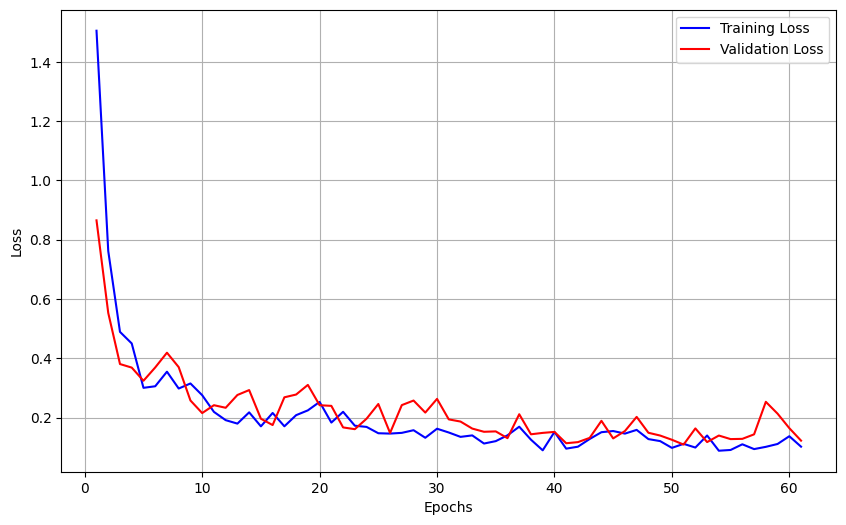

In [ ]:
plot_loss_curves(r"D:\Praharsha\code\CAMZ\models\model_history\5.0-Transformer\transformer_history.csv")